<a href="https://colab.research.google.com/github/VadimFarutin/neural-style-transfer/blob/master/baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from __future__ import print_function

import numpy as np
from tqdm import tnrange, tqdm_notebook
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
class ImageLoader():
    IMAGE_SIZE = 512 if torch.cuda.is_available() else 128

    def __init__(self):
        self.loader = transforms.Compose([
            transforms.Resize((ImageLoader.IMAGE_SIZE, ImageLoader.IMAGE_SIZE)),
            transforms.ToTensor()]
        )

    def load(self, path):
        image = Image.open(path)
        image = self.loader(image).unsqueeze(0)
        image = image.to(device, torch.float)
        return image


In [0]:
def imshow(tensor, title):
    unloader = transforms.ToPILImage()

    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.figure()
    plt.imshow(image)
    plt.xticks([]); plt.yticks([]);
    plt.title(title)


In [0]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [0]:
class StyleLoss(nn.Module):
    def gram_matrix(input):
        b, c, h, w = input.size()
        features = input.view(b * c, h * w) 
        G = torch.mm(features, features.t())

        return G.div(b * c * h * w)

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = StyleLoss.gram_matrix(target_feature).detach()

    def forward(self, input):
        G = StyleLoss.gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


In [0]:
class Normalization(nn.Module):
    MEAN = torch.tensor([0.485, 0.456, 0.406]).to(device)
    STD = torch.tensor([0.229, 0.224, 0.225]).to(device)

    def __init__(self, mean=None, std=None):
        super(Normalization, self).__init__()

        if mean is None:
            mean = Normalization.MEAN
        if std is None:
            std = Normalization.STD

        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std


In [0]:
class BaseModel(nn.Module):
    def __init__(self, cnn, style_img, content_img, content_layers, style_layers):
        super(BaseModel, self).__init__()

        cnn = copy.deepcopy(cnn)
        normalization = Normalization().to(device)
        model = nn.Sequential(normalization)

        content_losses = []
        style_losses = []

        last_loss_layer = 0
        conv_cnt = 0

        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                conv_cnt += 1
                name = 'conv_{}'.format(conv_cnt)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(conv_cnt)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(conv_cnt)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(conv_cnt)
            else:
                name = 'unknown_{}'.format(conv_cnt)
                
            model.add_module(name, layer)

            if name in content_layers:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(conv_cnt), content_loss)
                content_losses.append(content_loss)
                last_loss_layer = len(model)

            if name in style_layers:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(conv_cnt), style_loss)
                style_losses.append(style_loss)
                last_loss_layer = len(model)

        model = model[:(last_loss_layer)]

        self.model = model
        self.content_losses = content_losses
        self.style_losses = style_losses

    def get_content_losses(self, ):
        return self.content_losses

    def get_style_losses(self, ):
        return self.style_losses

    def forward(self, input):
        return self.model(input)


In [0]:
class Optimizer():
    def __init__(self, input_img):
        self.optimizer = optim.LBFGS([input_img.requires_grad_()])
    
    def zero_grad(self):
        self.optimizer.zero_grad()

    def step(self, optimizer_step):
        self.optimizer.step(optimizer_step)


In [0]:
def fit(model, optimizer, epoch_cnt, style_weight, content_weight):
    content_losses = model.get_content_losses()
    style_losses = model.get_style_losses()

    loss_values = []

    for epoch in tnrange(epoch_cnt):
        def optimizer_step():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)

            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            loss = style_score * style_weight + content_score * content_weight
            loss.backward()
            loss_values.append(loss.item())

            return loss.item()

        optimizer.step(optimizer_step)

    input_img.data.clamp_(0, 1)

    return input_img, loss_values


In [9]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:15<00:00, 36.2MB/s]


In [0]:
content_layer_names = ['conv_4']
style_layer_names = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

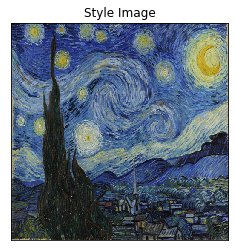

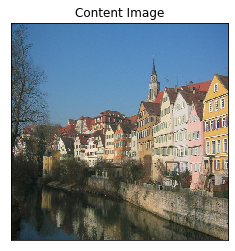

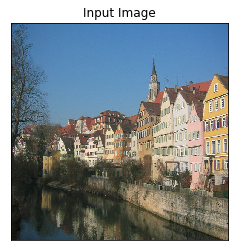

In [70]:
loader = ImageLoader()
# Images from Gatys
style_img = loader.load("./data/the-starry-night.jpg")
content_img = loader.load("./data/tubingen.jpg")
input_img = content_img.clone()
# input_img = torch.randn(content_img.data.size()).to(device)

imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')
imshow(input_img, title='Input Image')

In [0]:
model = BaseModel(cnn, style_img, content_img, content_layer_names, style_layer_names)
optimizer = Optimizer(input_img)
epoch_cnt = 10
content_weight = 1 # alpha
style_weight = 1000000 # beta

In [91]:
output, loss_values = fit(model, optimizer, epoch_cnt, style_weight, content_weight)

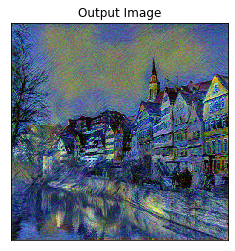

In [92]:
imshow(output, title='Output Image')

In [0]:
def plot_loss_values(loss_values):
    plt.plot(np.arange(len(loss_values)), loss_values, color='blue')
    plt.title("Loss values")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()

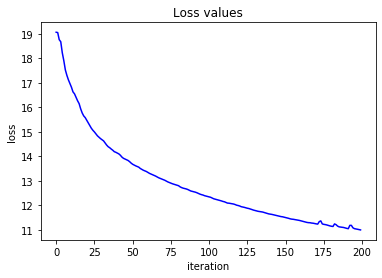

In [94]:
plot_loss_values(loss_values)